In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_online import ZSTL

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, False)
])

In [3]:
d = 8
dm = 5
T = 200
n = 20
dict_k = 6
shape_record = {}
shape_record[0] = [(1,d)]

def synthetic_binClass(d, dm, dict_k, T, n, random_state = 110):
    np.random.seed(110)
    L_gt = np.random.randn(d,dict_k)

    D_gt = np.random.randn(dm,dict_k)

    s = np.random.uniform(0, 2, size=(dict_k, T))
    s[s>=1] = 0

    ones = np.atleast_2d(np.ones(n))
    x = np.random.normal(0, 1.0, size=(d-1,n))*2
    x = np.vstack((ones, x))

    w = L_gt @ s
    a = D_gt @ s

    y = utils.sigmoid(w.T @ x)
    y[y >=0.5] = np.ones_like(y[y >=0.5])
    y[y <0.5] = np.zeros_like(y[y < 0.5])

    print('y ', np.sum(y, axis=1))

    a = a.T
    w = w.T
    x = x.T

    dataset = [(a[t,:], np.expand_dims(w[t,:], axis=0), x, np.expand_dims(y[t,:], axis=1)) for t in range(T)]

    print(a[1,:].shape, w[1,:].shape, x.shape, y[1,:].shape)
    return dataset

dataset = synthetic_binClass(d, dm, dict_k, T, n, random_state = 999)
print('len dataset ', len(dataset))
kb_size = 10
train_size = 140
total_len = len(dataset)
test_size = total_len - kb_size - train_size

indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
train_a, train_w, train_x, train_y = next(iter(train_loader))
train_a, train_w, train_x, train_y = train_a.float(), train_w.float(), train_x.float(), train_y.float()
print(train_a.shape, train_w.shape, train_x.shape, train_y.shape)

y  [12. 13. 17. 11.  7. 11. 11. 10.  8. 11. 11. 11. 11. 12. 17. 14. 15. 12.
 11.  8. 10. 14. 17. 17. 11. 16. 10. 10. 11. 12. 11. 11. 12. 16. 12. 11.
 11. 14. 14. 12. 17. 17.  9. 14. 11. 11. 12. 11. 13. 13. 10. 12. 12. 11.
 14. 16. 17. 14. 16. 13. 11. 15. 12. 12. 14. 15. 14. 16. 13. 13. 10. 13.
  9. 12. 10. 12. 12. 14. 10. 17. 11.  9. 11. 11. 10. 11. 14.  7. 12. 13.
 14. 12. 12. 11. 15. 15. 14. 13. 10. 14. 11. 11. 14. 16. 12. 17. 15. 12.
 13. 14. 11. 11. 20. 12. 11. 12. 14. 13. 12. 11. 12. 11. 11. 13. 14. 17.
 13. 12. 17. 12. 13. 16. 15.  7. 13. 13. 12. 11. 10. 16. 11. 11.  8. 10.
 13. 14.  9. 13.  8. 13. 20. 11. 10. 12. 11. 14. 11. 11. 11.  8.  9. 15.
 12. 14. 12. 12. 10. 14. 14. 13. 11. 10. 11. 13. 12. 14. 17. 17.  8. 16.
 11.  7. 14. 14. 13. 12. 11. 12. 15. 10. 14. 11. 12. 14. 11. 10. 14. 12.
 11. 11.]
(5,) (8,) (20, 8) (20,)
len dataset  200
10
140
50
torch.Size([140, 1, 5]) torch.Size([140, 1, 8]) torch.Size([140, 20, 8]) torch.Size([140, 20, 1])


{'rho': 1e-05, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
init mean test metric 0.8470000000000002; align loss 0.015483100898563862
num task  140
1/140 o_loss 0.09363747466704808; m test metric 0.839; align loss  0.014782731421291828
2/140 o_loss 0.07537883205804974; m test metric 0.7370000000000002; align loss  0.04690083861351013
3/140 o_loss 0.09237501202733256; m test metric 0.7880000000000001; align loss  0.027791455388069153
4/140 o_loss 0.0623520688386634; m test metric 0.7660000000000002; align loss  0.024887988343834877
5/140 o_loss 0.034515611769165844; m test metric 0.7830000000000001; align loss  0.025946181267499924
6/140 o_loss 0.008972421666840091; m test metric 0.8109999999999998; align loss  0.012781803496181965
7/140 o_loss 0.04621273570228368; m test metric 0.78; align loss  0.033365145325660706
8/140 o_loss 0.045498372230213135; m test metric 0.784; align

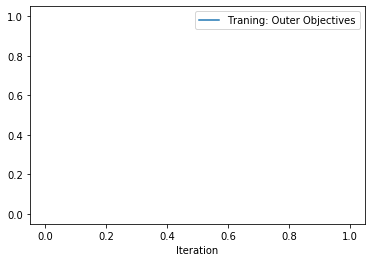

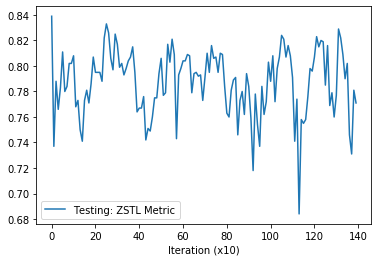

0

In [4]:
param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 1e-5
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)

support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()

ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)
ZSTL_model.train(train_loader, test_loader, max_iter=1000)

ic 0.78; align loss  2.5750973224639893
30/1500 o_loss 5.8457392423879355; m train metric 0.8395833333333337; m test metric 0.7775; align loss  1.8115177154541016
40/1500 o_loss 5.7444014159807315; m train metric 0.838333333333333; m test metric 0.7699999999999999; align loss  1.2546770572662354
50/1500 o_loss 5.645456183080872; m train metric 0.8275; m test metric 0.7725; align loss  0.8411913514137268
60/1500 o_loss 5.539282526603589; m train metric 0.8216666666666669; m test metric 0.7825; align loss  0.5392305254936218
70/1500 o_loss 5.446896821136276; m train metric 0.8158333333333333; m test metric 0.7699999999999998; align loss  0.32434338331222534
80/1500 o_loss 5.375979790091515; m train metric 0.8000000000000004; m test metric 0.7474999999999999; align loss  0.18316800892353058
90/1500 o_loss 5.294132426629464; m train metric 0.8095833333333332; m test metric 0.765; align loss  0.10308113694190979
100/1500 o_loss 5.193022672397395; m train metric 0.8175000000000003; m test me

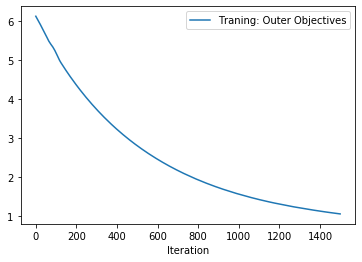

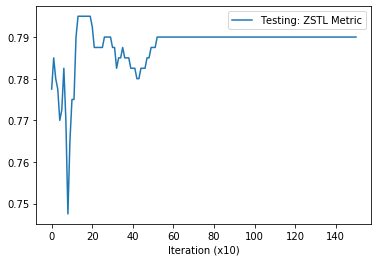

c 0.78; align loss  0.27143383026123047
30/1500 o_loss 5.846582292625681; m train metric 0.8400000000000003; m test metric 0.7774999999999999; align loss  0.19663546979427338
40/1500 o_loss 5.7445857480634; m train metric 0.8366666666666671; m test metric 0.7699999999999999; align loss  0.1424676477909088
50/1500 o_loss 5.643523172009736; m train metric 0.8279166666666667; m test metric 0.7724999999999999; align loss  0.10245835781097412
60/1500 o_loss 5.540139012504369; m train metric 0.8233333333333336; m test metric 0.7825; align loss  0.07338175177574158
70/1500 o_loss 5.447562246148785; m train metric 0.8170833333333334; m test metric 0.77; align loss  0.05289357900619507
80/1500 o_loss 5.3731048508236805; m train metric 0.8020833333333334; m test metric 0.7625; align loss  0.039691902697086334
90/1500 o_loss 5.283489771870276; m train metric 0.8041666666666667; m test metric 0.7575000000000001; align loss  0.035875603556632996
100/1500 o_loss 5.1908817977334065; m train metric 0.

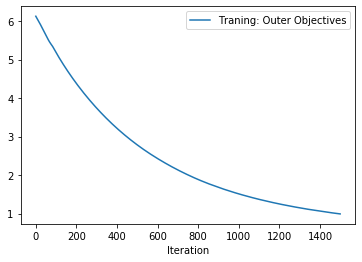

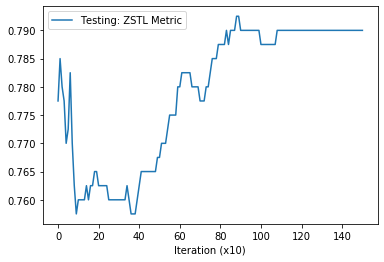

mean metric 0.7899999999999999
New best acc 0.7899999999999999
rho for w_kb 0.1; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 6.125453495668868; m train metric 0.8483333333333338; m test metric 0.78; align loss  0.0628473311662674
10/1500 o_loss 6.057331220371028; m train metric 0.847083333333334; m test metric 0.8025; align loss  0.04936688765883446
20/1500 o_loss 5.985336779927214; m train metric 0.8420833333333342; m test metric 0.8125; align loss  0.03855973109602928
30/1500 o_loss 5.912016006434957; m train metric 0.8425000000000006; m test metric 0.8074999999999999; align loss  0.032205574214458466
40/1500 o_loss 5.800835626013577; m train metric 0.8433333333333339; m test metric 0.8125; align loss  0.03171965852379799
50/1500 o_loss 5.692018625761072; m train metric 0.844166666666667; m test metric 0.8099999999999999; align loss  0.03127828985452652
60/1500 o_loss 5.587214080616832; m train metric 0.8454166666666669; m test metric 0

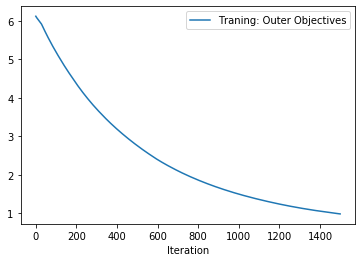

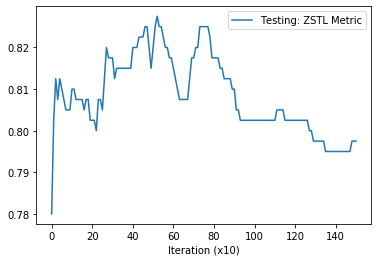

st metric 0.8150000000000001; align loss  0.010106520727276802
30/1500 o_loss 5.896167119778693; m train metric 0.84875; m test metric 0.8325000000000001; align loss  0.007560288533568382
40/1500 o_loss 5.7928239681757985; m train metric 0.8508333333333334; m test metric 0.8425000000000002; align loss  0.007089182734489441
50/1500 o_loss 5.682615394207339; m train metric 0.8533333333333335; m test metric 0.8450000000000001; align loss  0.0069747017696499825
60/1500 o_loss 5.580252911771337; m train metric 0.8562500000000003; m test metric 0.8450000000000001; align loss  0.006867540068924427
70/1500 o_loss 5.480212297166387; m train metric 0.8558333333333334; m test metric 0.8450000000000001; align loss  0.0067537156865000725
80/1500 o_loss 5.381810650539895; m train metric 0.8574999999999999; m test metric 0.8425; align loss  0.00663418136537075
90/1500 o_loss 5.2863116467371585; m train metric 0.8579166666666668; m test metric 0.8375; align loss  0.006515472196042538
100/1500 o_loss 5

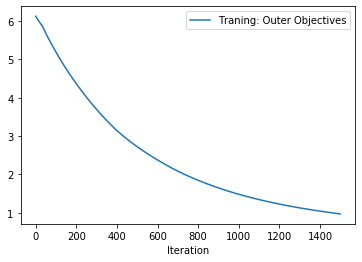

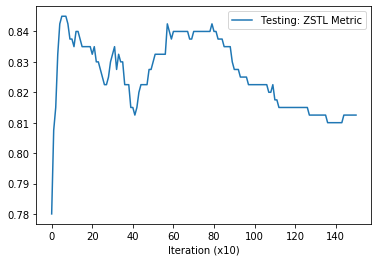

 0.8508333333333333; m test metric 0.78; align loss  0.015233292244374752
10/1500 o_loss 6.0347991526126865; m train metric 0.85125; m test metric 0.8099999999999999; align loss  0.010325704701244831
20/1500 o_loss 5.959344595484436; m train metric 0.8454166666666669; m test metric 0.82; align loss  0.006717743817716837
30/1500 o_loss 5.892866420124967; m train metric 0.8420833333333336; m test metric 0.8325000000000001; align loss  0.004461262375116348
40/1500 o_loss 5.803054661148538; m train metric 0.8449999999999996; m test metric 0.8325000000000001; align loss  0.003294518683105707
50/1500 o_loss 5.697251391550526; m train metric 0.8516666666666669; m test metric 0.8425; align loss  0.003123863600194454
60/1500 o_loss 5.592721303583433; m train metric 0.8525000000000003; m test metric 0.85; align loss  0.00306061003357172
70/1500 o_loss 5.493432786098371; m train metric 0.8550000000000003; m test metric 0.85; align loss  0.0029996633529663086
80/1500 o_loss 5.397047896745304; m tr

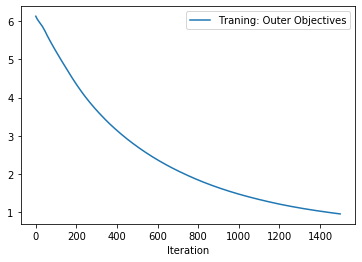

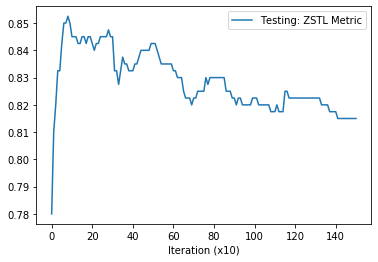

s 1.0630122658486167; m train metric 0.8466666666666666; m test metric 0.7775000000000001; align loss  4.777792930603027
10/1500 o_loss 1.059966162747393; m train metric 0.8458333333333338; m test metric 0.785; align loss  3.594327926635742
20/1500 o_loss 1.0591634075778225; m train metric 0.8445833333333334; m test metric 0.78; align loss  2.5751547813415527
30/1500 o_loss 1.048259140457958; m train metric 0.8395833333333338; m test metric 0.7749999999999998; align loss  1.8116238117218018
40/1500 o_loss 1.035133974812925; m train metric 0.8370833333333342; m test metric 0.77; align loss  1.2548203468322754
50/1500 o_loss 1.0234808058477938; m train metric 0.8283333333333336; m test metric 0.7725000000000001; align loss  0.841353714466095
60/1500 o_loss 1.002826648329695; m train metric 0.8208333333333343; m test metric 0.7825; align loss  0.5393962264060974
70/1500 o_loss 0.993536685158809; m train metric 0.8158333333333335; m test metric 0.77; align loss  0.3245072662830353
80/1500 

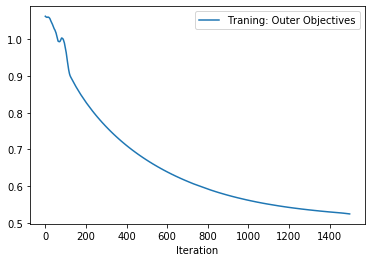

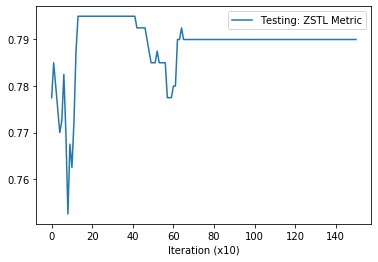

mean metric 0.7899999999999999
rho for w_kb 0.01; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 1.0630122658486167; m train metric 0.8466666666666672; m test metric 0.7775000000000001; align loss  0.49153345823287964
10/1500 o_loss 1.0598675054498017; m train metric 0.8462500000000001; m test metric 0.785; align loss  0.37258532643318176
20/1500 o_loss 1.0600006429788968; m train metric 0.8445833333333336; m test metric 0.78; align loss  0.27149081230163574
30/1500 o_loss 1.0491815075899162; m train metric 0.8395833333333336; m test metric 0.7749999999999998; align loss  0.19674204289913177
40/1500 o_loss 1.0354094635384778; m train metric 0.8375000000000002; m test metric 0.7699999999999999; align loss  0.14261233806610107
50/1500 o_loss 1.0216704809727768; m train metric 0.8283333333333335; m test metric 0.7725; align loss  0.1026243269443512
60/1500 o_loss 1.00397234071667; m train metric 0.8233333333333338; m test metric 0.78; align loss 

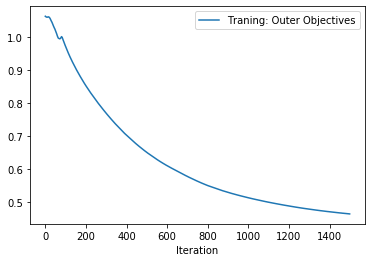

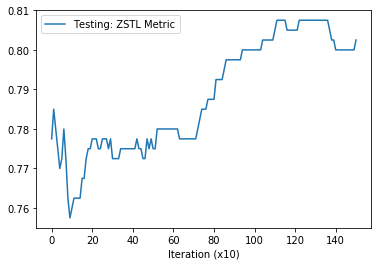

 1.0993093039219577; m train metric 0.8420833333333336; m test metric 0.8150000000000002; align loss  0.03860345482826233
30/1500 o_loss 1.1151657097041607; m train metric 0.8437500000000004; m test metric 0.8150000000000001; align loss  0.0325220488011837
40/1500 o_loss 1.0918085239206752; m train metric 0.84375; m test metric 0.8125; align loss  0.032151058316230774
50/1500 o_loss 1.0693850731477141; m train metric 0.8454166666666669; m test metric 0.8150000000000001; align loss  0.031818486750125885
60/1500 o_loss 1.0486685006568828; m train metric 0.8450000000000001; m test metric 0.8125; align loss  0.03147680312395096
70/1500 o_loss 1.0301695020248491; m train metric 0.8462500000000001; m test metric 0.8100000000000002; align loss  0.031149473041296005
80/1500 o_loss 1.012585816035668; m train metric 0.8441666666666673; m test metric 0.8100000000000002; align loss  0.030827157199382782
90/1500 o_loss 0.996266854989032; m train metric 0.8458333333333332; m test metric 0.8100000000

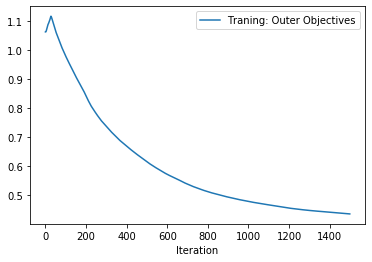

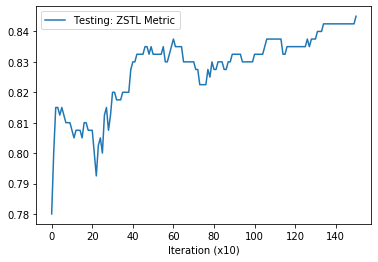

 metric 0.8449999999999999; m test metric 0.8149999999999998; align loss  0.010124699212610722
30/1500 o_loss 1.0996607386507093; m train metric 0.8495833333333334; m test metric 0.8350000000000002; align loss  0.00759150180965662
40/1500 o_loss 1.083924578006069; m train metric 0.8520833333333334; m test metric 0.8425; align loss  0.00711956899613142
50/1500 o_loss 1.0591178530516725; m train metric 0.8525000000000001; m test metric 0.8425; align loss  0.006998923607170582
60/1500 o_loss 1.0410409392789006; m train metric 0.8558333333333336; m test metric 0.8425; align loss  0.006884189788252115
70/1500 o_loss 1.0245394862877826; m train metric 0.8570833333333333; m test metric 0.8425; align loss  0.006770962383598089
80/1500 o_loss 1.007518470349411; m train metric 0.8583333333333336; m test metric 0.8425; align loss  0.006660887040197849
90/1500 o_loss 0.9911734373619159; m train metric 0.8595833333333339; m test metric 0.8375; align loss  0.006560571026057005
100/1500 o_loss 0.9758

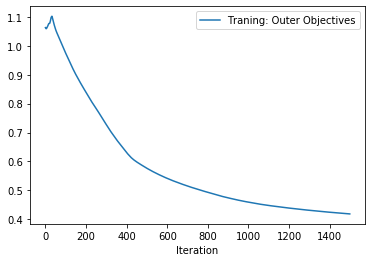

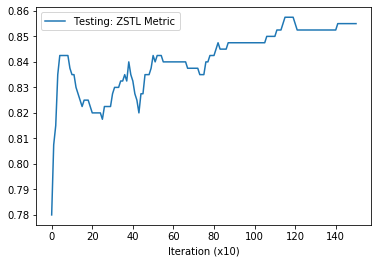

ic 0.8425000000000004; m test metric 0.8325000000000001; align loss  0.004485872108489275
40/1500 o_loss 1.0939128617135188; m train metric 0.8466666666666669; m test metric 0.8324999999999999; align loss  0.003318340051919222
50/1500 o_loss 1.0744854176727434; m train metric 0.8520833333333335; m test metric 0.8375; align loss  0.0031246421858668327
60/1500 o_loss 1.053914157083879; m train metric 0.85375; m test metric 0.8474999999999998; align loss  0.003059149719774723
70/1500 o_loss 1.0369762695704896; m train metric 0.8570833333333339; m test metric 0.8474999999999998; align loss  0.002995789051055908
80/1500 o_loss 1.020662825088948; m train metric 0.8566666666666671; m test metric 0.85; align loss  0.0029365625232458115
90/1500 o_loss 1.005546746775508; m train metric 0.8554166666666669; m test metric 0.8474999999999998; align loss  0.002881009131669998
100/1500 o_loss 0.9912243686926862; m train metric 0.8554166666666664; m test metric 0.8424999999999999; align loss  0.0028296

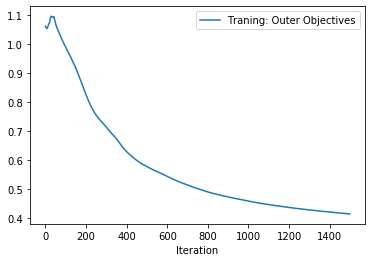

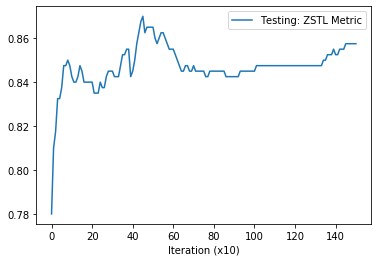

mean metric 0.8574999999999999
New best acc 0.8574999999999999
rho for w_kb 0.001; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 0.5567681689436237; m train metric 0.8466666666666669; m test metric 0.7775; align loss  4.777794361114502
10/1500 o_loss 0.5612844249544044; m train metric 0.8462500000000003; m test metric 0.7825; align loss  3.5943756103515625
20/1500 o_loss 0.5690178799132506; m train metric 0.845; m test metric 0.7849999999999999; align loss  2.5753111839294434
30/1500 o_loss 0.566820670478046; m train metric 0.8395833333333339; m test metric 0.7749999999999998; align loss  1.8119298219680786
40/1500 o_loss 0.5624181577004492; m train metric 0.8366666666666668; m test metric 0.7699999999999999; align loss  1.2552939653396606
50/1500 o_loss 0.5600830677275856; m train metric 0.8291666666666672; m test metric 0.7725; align loss  0.8419986367225647
60/1500 o_loss 0.5484189285586278; m train metric 0.8212500000000004; m test metric 0.7

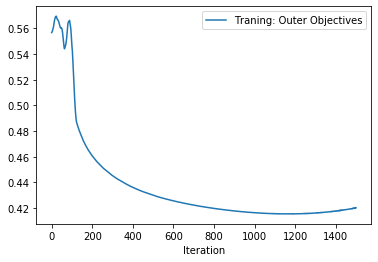

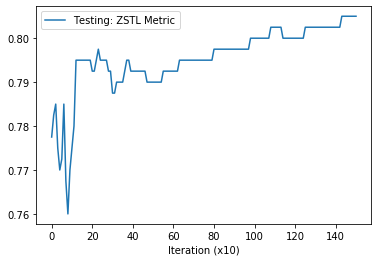

n loss 0.5069708824157715
1/1500 o_loss 0.5567681689436237; m train metric 0.846666666666667; m test metric 0.7775; align loss  0.4915352165699005
10/1500 o_loss 0.5611866892005006; m train metric 0.8458333333333335; m test metric 0.7825; align loss  0.3726329505443573
20/1500 o_loss 0.5699242372065783; m train metric 0.8450000000000003; m test metric 0.7825; align loss  0.27164342999458313
30/1500 o_loss 0.5677644233219326; m train metric 0.8400000000000006; m test metric 0.7749999999999999; align loss  0.19704291224479675
40/1500 o_loss 0.5627139014191925; m train metric 0.8358333333333334; m test metric 0.7699999999999999; align loss  0.14307954907417297
50/1500 o_loss 0.558232202846557; m train metric 0.8295833333333335; m test metric 0.7724999999999999; align loss  0.10326322913169861
60/1500 o_loss 0.5496727328126629; m train metric 0.8233333333333336; m test metric 0.78; align loss  0.07434707880020142
70/1500 o_loss 0.5484877431144317; m train metric 0.816666666666667; m test m

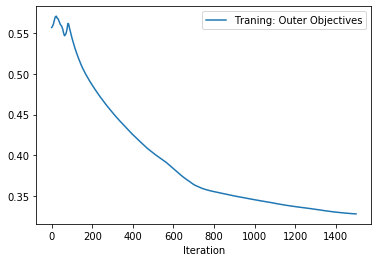

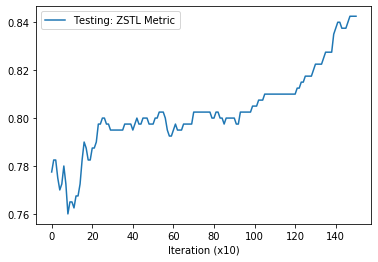

7; m train metric 0.8483333333333335; m test metric 0.78; align loss  0.06285075843334198
10/1500 o_loss 0.5799577799004813; m train metric 0.8466666666666671; m test metric 0.8; align loss  0.049412164837121964
20/1500 o_loss 0.6095289413506786; m train metric 0.8420833333333337; m test metric 0.8125; align loss  0.038707830011844635
30/1500 o_loss 0.6319554983948668; m train metric 0.844166666666667; m test metric 0.8125; align loss  0.03310147672891617
40/1500 o_loss 0.6148099987457196; m train metric 0.8441666666666666; m test metric 0.8149999999999998; align loss  0.03296786919236183
50/1500 o_loss 0.599634902117153; m train metric 0.8450000000000002; m test metric 0.8125; align loss  0.03287752717733383
60/1500 o_loss 0.5870007393260797; m train metric 0.8454166666666667; m test metric 0.8099999999999999; align loss  0.03276021406054497
70/1500 o_loss 0.5760174894084533; m train metric 0.8462499999999998; m test metric 0.8099999999999999; align loss  0.03264787793159485
80/1500 o

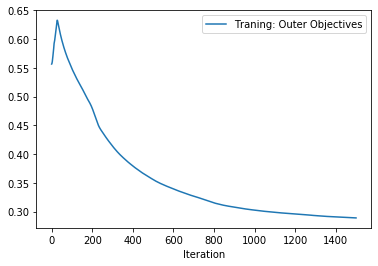

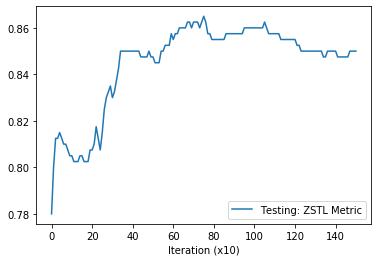

5; align loss  0.0076933554373681545
40/1500 o_loss 0.6016634011951586; m train metric 0.8524999999999998; m test metric 0.8400000000000001; align loss  0.007361717522144318
50/1500 o_loss 0.5831971294557055; m train metric 0.8533333333333335; m test metric 0.8400000000000001; align loss  0.0073389774188399315
60/1500 o_loss 0.5712723086898526; m train metric 0.8554166666666667; m test metric 0.8400000000000001; align loss  0.007312558591365814
70/1500 o_loss 0.5612402498101194; m train metric 0.8579166666666667; m test metric 0.8375; align loss  0.007282683160156012
80/1500 o_loss 0.5515895509471496; m train metric 0.8604166666666672; m test metric 0.8324999999999999; align loss  0.007251633331179619
90/1500 o_loss 0.5428141972050071; m train metric 0.8612500000000005; m test metric 0.8324999999999999; align loss  0.007224007043987513
100/1500 o_loss 0.5343597113465269; m train metric 0.8625000000000005; m test metric 0.8324999999999999; align loss  0.007200045511126518
110/1500 o_los

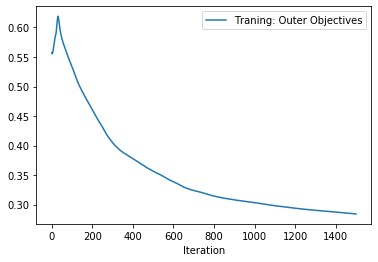

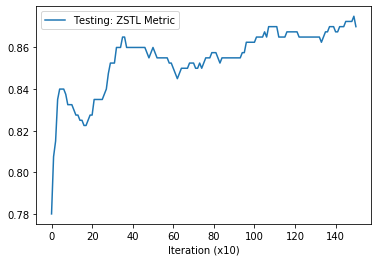

 train metric 0.8450000000000001; m test metric 0.8299999999999998; align loss  0.004549205303192139
40/1500 o_loss 0.6195142429942886; m train metric 0.8479166666666674; m test metric 0.8299999999999998; align loss  0.003422495676204562
50/1500 o_loss 0.6021782233690222; m train metric 0.8525000000000001; m test metric 0.8324999999999999; align loss  0.0032520426902920008
60/1500 o_loss 0.5853439688992997; m train metric 0.8554166666666667; m test metric 0.845; align loss  0.003239157609641552
70/1500 o_loss 0.5732546133610109; m train metric 0.8587500000000002; m test metric 0.845; align loss  0.0032234617974609137
80/1500 o_loss 0.5625790057393412; m train metric 0.8595833333333335; m test metric 0.8525; align loss  0.003206024644896388
90/1500 o_loss 0.5530804743679861; m train metric 0.8604166666666673; m test metric 0.8550000000000001; align loss  0.003190350253134966
100/1500 o_loss 0.5440666136021415; m train metric 0.8616666666666671; m test metric 0.8550000000000001; align lo

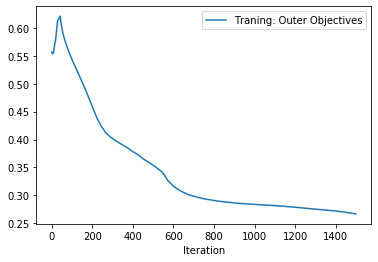

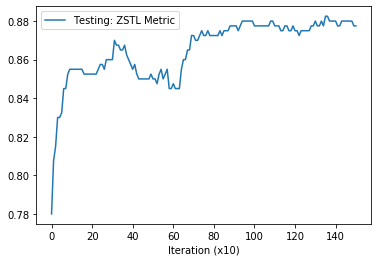

mean metric 0.8774999999999998
New best acc 0.8774999999999998
rho for w_kb 0.0001; mu for a_kb 0.1;
init mean test metric 0.7800000000000001; align loss 4.9283766746521
1/1500 o_loss 0.5061437564591567; m train metric 0.8466666666666669; m test metric 0.7775000000000001; align loss  4.777791500091553
10/1500 o_loss 0.5111892155371607; m train metric 0.84625; m test metric 0.7825000000000001; align loss  3.594341993331909
20/1500 o_loss 0.5194887025902669; m train metric 0.8450000000000004; m test metric 0.785; align loss  2.5752451419830322
30/1500 o_loss 0.5179235018168886; m train metric 0.8395833333333339; m test metric 0.7750000000000001; align loss  1.8118603229522705
40/1500 o_loss 0.5143121881100039; m train metric 0.8362500000000003; m test metric 0.7700000000000002; align loss  1.2552781105041504
50/1500 o_loss 0.51318568745628; m train metric 0.82875; m test metric 0.7725000000000002; align loss  0.8420661091804504
60/1500 o_loss 0.5025549757294356; m train metric 0.82208333

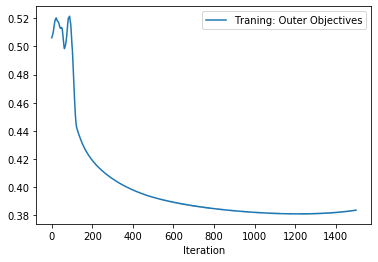

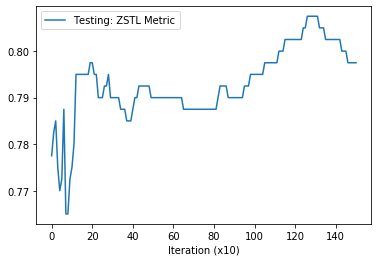

 test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 0.5061437564591567; m train metric 0.8466666666666671; m test metric 0.7775; align loss  0.49153244495391846
10/1500 o_loss 0.5110919158595304; m train metric 0.8462500000000003; m test metric 0.7825; align loss  0.3725994825363159
20/1500 o_loss 0.5204174130844573; m train metric 0.8450000000000005; m test metric 0.7825; align loss  0.2715781033039093
30/1500 o_loss 0.5188729354490836; m train metric 0.8400000000000004; m test metric 0.7749999999999998; align loss  0.19697411358356476
40/1500 o_loss 0.5146936409796278; m train metric 0.8358333333333339; m test metric 0.7699999999999998; align loss  0.14306387305259705
50/1500 o_loss 0.5114059789416691; m train metric 0.8295833333333335; m test metric 0.7724999999999997; align loss  0.10332923382520676
60/1500 o_loss 0.5038291346592207; m train metric 0.8245833333333334; m test metric 0.7824999999999999; align loss  0.07449290156364441
70/1500 o_loss 0.5028431026575466; m t

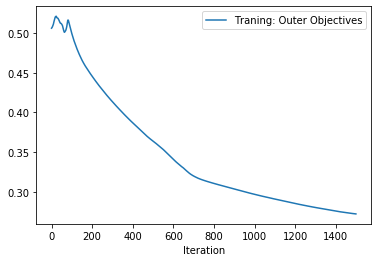

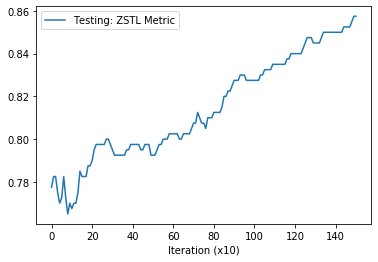

.8450000000000001; m test metric 0.8125; align loss  0.03306666016578674
50/1500 o_loss 0.5510117563419044; m train metric 0.8454166666666668; m test metric 0.8125; align loss  0.03299010917544365
60/1500 o_loss 0.538641461605827; m train metric 0.8470833333333335; m test metric 0.8099999999999999; align loss  0.03291911631822586
70/1500 o_loss 0.5280694329800705; m train metric 0.8462499999999998; m test metric 0.8074999999999999; align loss  0.03284618258476257
80/1500 o_loss 0.5190202600322664; m train metric 0.8458333333333332; m test metric 0.8049999999999999; align loss  0.0327826663851738
90/1500 o_loss 0.5107596823324759; m train metric 0.8479166666666667; m test metric 0.8049999999999999; align loss  0.03271620720624924
100/1500 o_loss 0.5030680723798772; m train metric 0.8483333333333334; m test metric 0.8024999999999999; align loss  0.0326523594558239
110/1500 o_loss 0.4960147213501235; m train metric 0.8504166666666669; m test metric 0.8024999999999999; align loss  0.032590

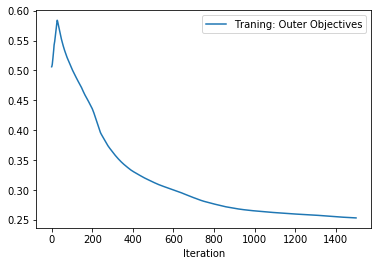

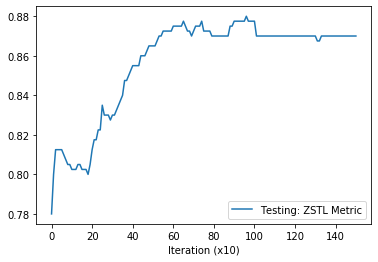

4462703764439
40/1500 o_loss 0.5517335363974174; m train metric 0.8525000000000004; m test metric 0.8400000000000002; align loss  0.00742302043363452
50/1500 o_loss 0.533953657001257; m train metric 0.8554166666666667; m test metric 0.8400000000000002; align loss  0.0074235666543245316
60/1500 o_loss 0.5224222269840538; m train metric 0.8570833333333339; m test metric 0.8375; align loss  0.007420097477734089
70/1500 o_loss 0.5119357885792851; m train metric 0.8595833333333335; m test metric 0.8375; align loss  0.007416596636176109
80/1500 o_loss 0.5023716181827088; m train metric 0.8612500000000003; m test metric 0.8324999999999999; align loss  0.007411768194288015
90/1500 o_loss 0.49333049229656656; m train metric 0.8616666666666671; m test metric 0.8324999999999999; align loss  0.007409411948174238
100/1500 o_loss 0.48352640261873603; m train metric 0.8637500000000002; m test metric 0.8324999999999999; align loss  0.007409997750073671
110/1500 o_loss 0.4743827922269702; m train metri

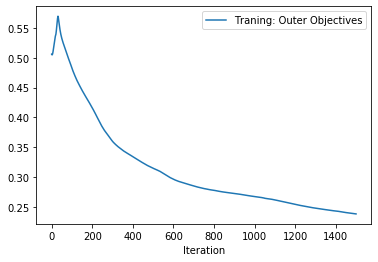

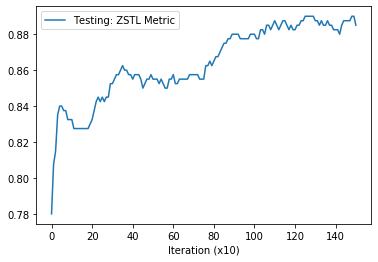

19485579431057
1/1500 o_loss 0.5061437564591567; m train metric 0.8508333333333339; m test metric 0.78; align loss  0.01523341704159975
10/1500 o_loss 0.5066177830100059; m train metric 0.8508333333333337; m test metric 0.8075000000000001; align loss  0.01031453162431717
20/1500 o_loss 0.531618030089885; m train metric 0.8450000000000006; m test metric 0.8175000000000001; align loss  0.0067245191894471645
30/1500 o_loss 0.5650099486423036; m train metric 0.841666666666667; m test metric 0.8325000000000001; align loss  0.004531928338110447
40/1500 o_loss 0.5679016117937863; m train metric 0.8462500000000005; m test metric 0.825; align loss  0.0034220092929899693
50/1500 o_loss 0.5530506764849027; m train metric 0.8520833333333336; m test metric 0.8324999999999999; align loss  0.0032781895715743303
60/1500 o_loss 0.5389024675823748; m train metric 0.8558333333333337; m test metric 0.845; align loss  0.0032666437327861786
70/1500 o_loss 0.5278683256357908; m train metric 0.859583333333333

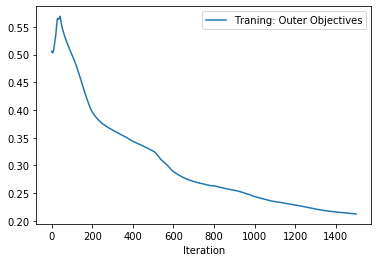

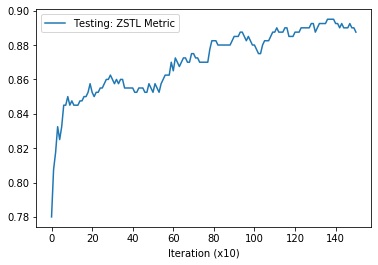

best acc 0.8874999999999998
rho for w_kb 1e-05; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 0.501081315757862; m train metric 0.8466666666666666; m test metric 0.7775000000000001; align loss  4.777791500091553
10/1500 o_loss 0.5061599501874298; m train metric 0.8462500000000001; m test metric 0.7825; align loss  3.5943315029144287
20/1500 o_loss 0.5145032958399194; m train metric 0.8450000000000003; m test metric 0.7849999999999999; align loss  2.575225591659546
30/1500 o_loss 0.5129868375098643; m train metric 0.8395833333333338; m test metric 0.7749999999999998; align loss  1.8118348121643066
40/1500 o_loss 0.5094806291318188; m train metric 0.8362500000000002; m test metric 0.7699999999999999; align loss  1.255260944366455
50/1500 o_loss 0.5083496138259458; m train metric 0.8287500000000001; m test metric 0.7725; align loss  0.842054009437561
60/1500 o_loss 0.4977444845406959; m train metric 0.8225000000000001; m test metric 0.78749999999999

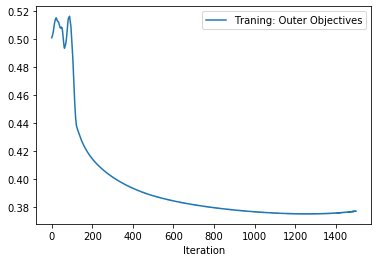

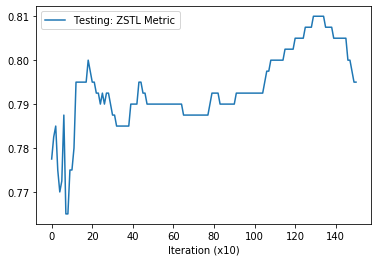

mean metric 0.7949999999999999
rho for w_kb 1e-05; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 0.501081315757862; m train metric 0.846666666666667; m test metric 0.7775000000000001; align loss  0.4915321469306946
10/1500 o_loss 0.5060631597802664; m train metric 0.8462500000000003; m test metric 0.7825; align loss  0.3725890517234802
20/1500 o_loss 0.515429755676693; m train metric 0.8450000000000004; m test metric 0.7825; align loss  0.271558552980423
30/1500 o_loss 0.5139306074047151; m train metric 0.8400000000000003; m test metric 0.7749999999999998; align loss  0.19694778323173523
40/1500 o_loss 0.509815860632807; m train metric 0.8358333333333338; m test metric 0.7699999999999999; align loss  0.1430468112230301
50/1500 o_loss 0.5066469223548968; m train metric 0.8295833333333336; m test metric 0.7725; align loss  0.10331703722476959
60/1500 o_loss 0.49904094957746564; m train metric 0.8245833333333336; m test metric 0.7825; align loss

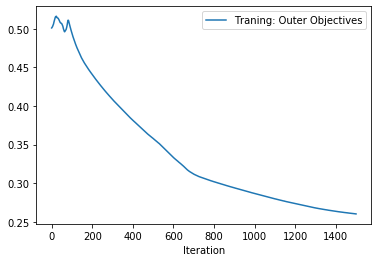

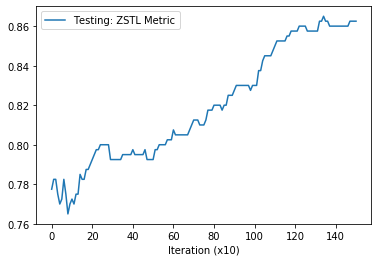

st metric 0.8125; align loss  0.0386572927236557
30/1500 o_loss 0.5773732400576894; m train metric 0.8445833333333337; m test metric 0.8125; align loss  0.03320379555225372
40/1500 o_loss 0.5608105845438938; m train metric 0.8454166666666668; m test metric 0.8150000000000001; align loss  0.03308836370706558
50/1500 o_loss 0.545870081296501; m train metric 0.8454166666666674; m test metric 0.8125; align loss  0.03302072361111641
60/1500 o_loss 0.5333978632465005; m train metric 0.8466666666666665; m test metric 0.8099999999999999; align loss  0.03295569866895676
70/1500 o_loss 0.5228251993268107; m train metric 0.8462500000000001; m test metric 0.8075000000000001; align loss  0.03289497643709183
80/1500 o_loss 0.5139420519117266; m train metric 0.8462500000000001; m test metric 0.805; align loss  0.032837167382240295
90/1500 o_loss 0.5056399479236764; m train metric 0.8466666666666671; m test metric 0.805; align loss  0.03278578817844391
100/1500 o_loss 0.4980205092035855; m train metri

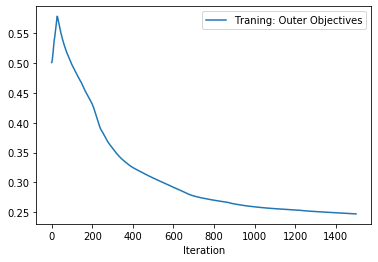

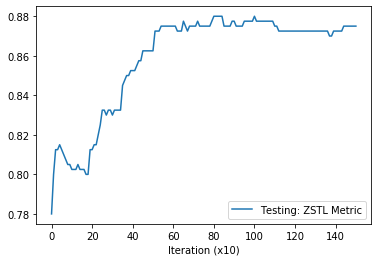

ric 0.8491666666666671; m test metric 0.835; align loss  0.007698269095271826
40/1500 o_loss 0.5469275118977142; m train metric 0.8525000000000001; m test metric 0.8399999999999999; align loss  0.00745723582804203
50/1500 o_loss 0.529133147521255; m train metric 0.8558333333333331; m test metric 0.8399999999999999; align loss  0.007465924136340618
60/1500 o_loss 0.5177003494890717; m train metric 0.8562500000000004; m test metric 0.8375; align loss  0.007466658018529415
70/1500 o_loss 0.5071892817388288; m train metric 0.8595833333333336; m test metric 0.835; align loss  0.007466229610145092
80/1500 o_loss 0.497665872622747; m train metric 0.8608333333333336; m test metric 0.8324999999999999; align loss  0.0074661774560809135
90/1500 o_loss 0.48840611721388993; m train metric 0.8616666666666669; m test metric 0.8324999999999999; align loss  0.007470151409506798
100/1500 o_loss 0.4783496605542799; m train metric 0.864166666666667; m test metric 0.8324999999999999; align loss  0.00747677

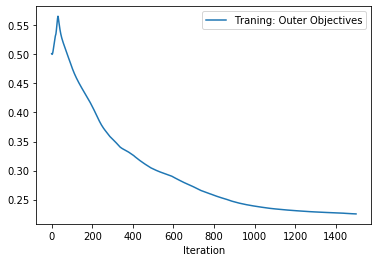

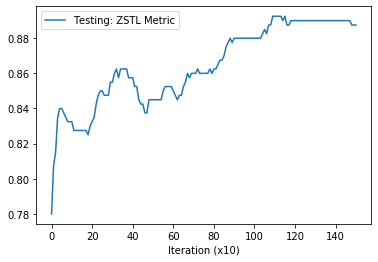

99999999; align loss  0.010311534628272057
20/1500 o_loss 0.5267839818572004; m train metric 0.8450000000000003; m test metric 0.8175000000000001; align loss  0.006718930788338184
30/1500 o_loss 0.5599675955755326; m train metric 0.8416666666666669; m test metric 0.8325000000000001; align loss  0.004524888005107641
40/1500 o_loss 0.5626518699301717; m train metric 0.846666666666667; m test metric 0.825; align loss  0.0034130183048546314
50/1500 o_loss 0.5479730430563602; m train metric 0.8520833333333334; m test metric 0.8324999999999999; align loss  0.0032654176466166973
60/1500 o_loss 0.5337897518960139; m train metric 0.8566666666666671; m test metric 0.845; align loss  0.0032513935584574938
70/1500 o_loss 0.5227811088552698; m train metric 0.8595833333333333; m test metric 0.845; align loss  0.0032377049792557955
80/1500 o_loss 0.5129579561762512; m train metric 0.8595833333333336; m test metric 0.8475000000000001; align loss  0.0032233463134616613
90/1500 o_loss 0.5038571413218355

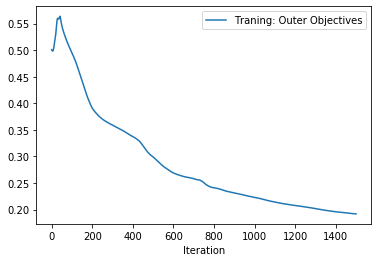

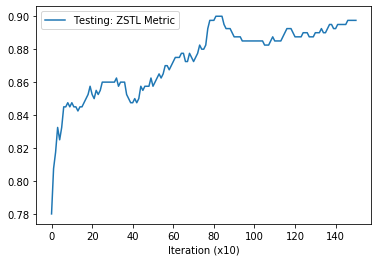

mean metric 0.8975
New best acc 0.8975
best_hp  {'mu': 1e-05, 'rho': 1e-05}


In [5]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)


indx = train_indx
val_indx = list(np.random.choice(indx, size=20, replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data = utils.Dataset([dataset[d] for d in val_indx])
train_splited_data = utils.Dataset([dataset[d] for d in train_indx_splited])
val_loader = DataLoader(val_data, batch_size=len(val_indx), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=len(train_indx_splited), shuffle=True)

best_hp = utils.hp_select_binClass(train_splited_loader, val_loader, support_loader, d, dm, net, shape_record)
print('best_hp ', best_hp)

5
{'rho': 1e-05, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
init mean test metric 0.8469999999999999; align loss 0.015483100898563862
num task  140
1/140 o_loss 0.01814887300133705; m test metric 0.8230000000000001; align loss  0.0252555999904871
2/140 o_loss 0.04844831008813344; m test metric 0.8040000000000002; align loss  0.02462935447692871
3/140 o_loss 0.045427574310451746; m test metric 0.7939999999999996; align loss  0.030179815366864204
4/140 o_loss 0.09193800002685748; m test metric 0.801; align loss  0.014408232644200325
5/140 o_loss 0.037616165849613026; m test metric 0.8250000000000002; align loss  0.01166752353310585
6/140 o_loss 0.14748750842409208; m test metric 0.8250000000000003; align loss  0.010838650166988373
7/140 o_loss 0.03162127546966076; m test metric 0.8290000000000002; align loss  0.013634653761982918
8/140 o_loss 0.0058732006582431495; m test metr

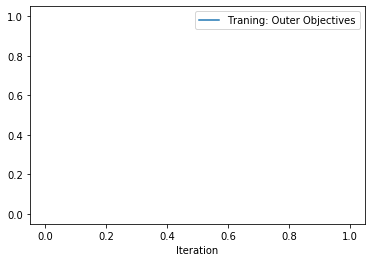

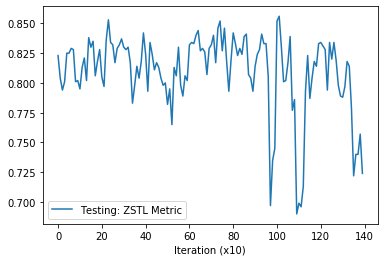

0

In [6]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)

param_dict = {}
param_dict['rho'] = best_hp['rho']
param_dict['mu'] = best_hp['mu']
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)


ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)
ZSTL_model.train(train_loader, test_loader, max_iter=1800)


In [ ]:
def genSplits(dataset, train_size, test_size, support_size, T, train_batch_size=140):
    indx = [ x for x in range(len(dataset))]
    support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
    print(len(support_indx))
    temp = [x for x in indx if x not in support_indx]
    train_indx = list(np.random.choice(temp, size=train_size, replace=False))
    temp = [x for x in temp if x not in train_indx]
    print(len(train_indx))
    test_indx = temp
    print(len(test_indx))


    support_data = utils.Dataset([dataset[d] for d in support_indx])
    train_data = utils.Dataset([dataset[d] for d in train_indx])
    test_data = utils.Dataset([dataset[d] for d in test_indx])

    support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)

    return support_loader, train_loader, test_loader

train_size1 = 140
test_size1 = 50
support_size1 = 10
support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)

In [ ]:
exp_results = []
Run = 10
print(param_dict)
for r in range(Run):
    support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)
    ZSTL_model.train(train_loader, test_loader, max_iter=1800)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    exp_results.append(utils.toNumpy(mean_acc))

import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

In [ ]:
import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)